## Анализ роста Charge
Подходит для анализа роста на данных с небольшой девиацией.<br>
Анализ выполняется с помощью поиска min, max, std значений

In [2]:
import pyodbc
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [12]:
# Download data from OCS DB

start_date = '2020-04-01 00:00:00'
end_date = '2020-07-14 00:00:00'

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
SELECT
CONVERT(VARCHAR, FIRST_SLICE_DATE, 3) AS REP_DATE
,mcc,mnc,reseller_id AS reseller_id, account_id AS account_id
,SUM(quantity) AS quantity
,ROUND(SUM(RESELLER_COST), 0) AS cost
,ROUND(SUM(RESELLER_CHARGE), 0) AS charge
FROM [10028_usage].[dbo].SESSION_AGGREGATION
WHERE FIRST_SLICE_DATE >= 
''' + "'" + start_date + "' and FIRST_SLICE_DATE < '" + end_date + "' " +\
'''
GROUP BY CONVERT(VARCHAR, FIRST_SLICE_DATE, 3),mcc,mnc,reseller_id,account_id
'''

df = pd.read_sql_query(sql_srt, cnxn, parse_dates={'REP_DATE': '%d/%m/%y'})
cnxn.close()

df['account_id']=df['account_id'].astype(int)

df.head()

,REP_DATE,mcc,mnc,reseller_id,account_id,quantity,cost,charge
0,2020-06-28,206,20,172794.0,352891,91372834.0,0.0,0.0
1,2020-04-25,525,6,172804.0,352790,374496.0,0.0,0.0
2,2020-07-07,238,6,172720.0,352725,33693237.0,0.0,0.0
3,2020-04-23,250,1,172794.0,352827,79542348.0,8.0,16.0
4,2020-07-03,244,91,172720.0,352869,834311.0,0.0,0.0


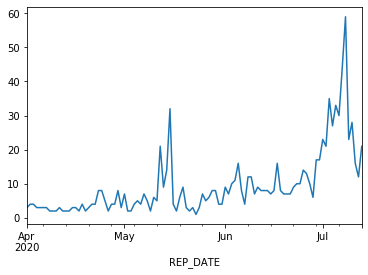

In [14]:
# Europe+ (352869)
df[df.account_id == 352869].groupby('REP_DATE', as_index=False)['cost','charge'].sum()
df_temp = df[df.account_id == 352869].groupby('REP_DATE', as_index=False)['cost','charge'].sum()
df_temp.set_index('REP_DATE')['charge'].plot()
plt.show()

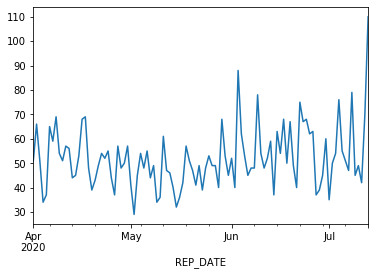

In [15]:
# New Simcards (352725)
df[df.account_id == 352725].groupby('REP_DATE', as_index=False)['cost','charge'].sum()
df_temp = df[df.account_id == 352725].groupby('REP_DATE', as_index=False)['cost','charge'].sum()
df_temp.set_index('REP_DATE')['charge'].plot()
plt.show()

In [16]:
# Prepare functions

def f(df_x):
    if df_x['charge','mean']==0:
        df_x['std_per']=0
    else:
        df_x['std_per']=round(df_x['charge','std']*100/df_x['charge','mean'],1)
    df_x['diff']=round(df_x['charge','max']-df_x['charge','min'],1)
    return df_x

### By country

In [17]:
# Find out the country with the biggest increase

df1=df.groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
# df1=df[df.account_id == 352869].groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head(10)

charge                                std_per  diff
       sum  min      mean   max       std              
mcc                                                    
214   50.0  0.0  0.480769  39.0  3.851568   801.1  39.0
262  179.0  0.0  1.864583  27.0  3.862423   207.1  27.0
232  160.0  0.0  1.538462  17.0  2.515672   163.5  17.0
240  162.0  0.0  1.557692  12.0  1.868632   120.0  12.0
222   97.0  0.0  0.932692   8.0  1.263870   135.5   8.0
234  204.0  0.0  1.961538   8.0  1.794939    91.5   8.0
238   73.0  0.0  0.879518   6.0  1.172839   133.4   6.0
228    9.0  0.0  0.600000   4.0  1.121224   186.9   4.0
272   30.0  0.0  0.288462   3.0  0.602149   208.7   3.0
293    5.0  0.0  0.333333   2.0  0.723747   217.1   2.0

                    quantity  cost  charge
REP_DATE   mcc                            
2020-04-02 262  4.609020e+05   0.0     0.0
2020-04-03 262  8.032000e+03   0.0     0.0
2020-04-04 262  3.523100e+04   0.0     0.0
2020-04-05 262  1.212449e+06   0.0     0.0
2020-04-08 262  6.220000e+03   0.0     0.0
...                      ...   ...     ...
2020-07-09 262  1.376874e+09   2.0     7.0
2020-07-10 262  2.207390e+09   4.0    10.0
2020-07-11 262  6.049355e+08   1.0     2.0
2020-07-12 262  5.915224e+08   1.0     2.0
2020-07-13 262  1.660389e+09   6.0    12.0

[96 rows x 3 columns] 



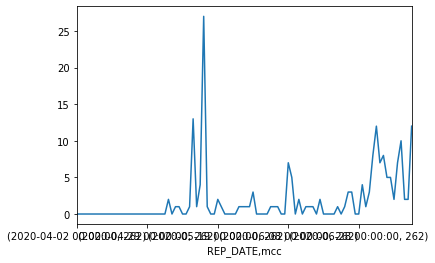

In [18]:
# Generate stat report by country

mcc = 262

df3=df1[df1.index.get_level_values('mcc')==mcc].sort_index(level=['mcc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By operator

In [9]:
# Find out the operator with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per   diff
            sum    min        mean    max         std               
mcc mnc                                                             
208 29    753.0    0.0   57.923077  735.0  203.447561   351.2  735.0
302 720  2886.0  146.0  222.000000  378.0   74.082162    33.4  232.0
228 3     559.0    8.0   43.000000  155.0   49.976661   116.2  147.0
234 10    607.0   17.0   46.692308  152.0   34.412654    73.7  135.0
250 28   1914.0   87.0  147.230769  211.0   37.027363    25.1  124.0

                       quantity   cost  charge
REP_DATE   mcc mnc                            
2020-07-01 208 29   173910564.0    1.0     2.0
2020-07-02 208 29    41788910.0    0.0     0.0
2020-07-03 208 29   339104483.0    2.0     3.0
2020-07-04 208 29      664459.0    0.0     0.0
2020-07-05 208 29    59773630.0  367.0   735.0
2020-07-06 208 29     5158968.0    0.0     0.0
2020-07-07 208 29      227788.0    0.0     0.0
2020-07-08 208 29      173637.0    0.0     0.0
2020-07-09 208 29     4613334.0    0.0     0.0
2020-07-10 208 29    13805481.0    0.0     0.0
2020-07-11 208 29   101156862.0    2.0     2.0
2020-07-12 208 29   353234215.0    2.0     4.0
2020-07-13 208 29   763080657.0    4.0     7.0 



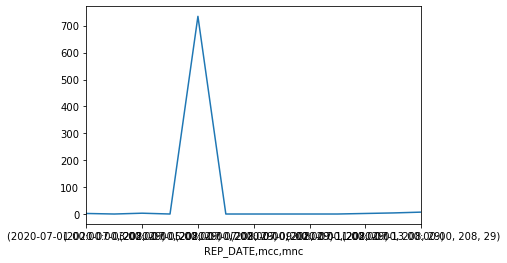

In [10]:
# Generate stat report by country

mcc = 208
mnc = 29

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By customer

In [11]:
# Find out the customer with the biggest increase in Country

df1 = df.groupby(['REP_DATE','mcc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity'] = round(df1['quantity'],1)
df1['charge'] = round(df1['charge'],1)
df1['cost'] = round(df1['cost'],1)

df2=df1.groupby(level=['mcc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per   diff
                   sum    min        mean    max         std               
mcc account_id                                                             
208 172875       754.0    0.0   68.545455  735.0  221.050837   322.5  735.0
302 172854      2665.0  144.0  205.000000  347.0   56.413651    27.5  203.0
    172875       366.0    1.0   28.153846  188.0   50.675185   180.0  187.0
228 172875       287.0    0.0   22.076923  148.0   49.636112   224.8  148.0
234 172844      4853.0  303.0  373.307692  422.0   40.733656    10.9  119.0

In [12]:
df_352406 = df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).reset_index()
df_352406 = df_352406[df_352406.account_id == 172720]
df_352406.head()

mcc account_id charge                                    std_per   diff
                      sum   min       mean    max        std               
6   240     172720  971.0  42.0  74.692308  157.0  34.991391    46.8  115.0
14  214     172720   59.0   0.0   4.538462   45.0  12.231213   269.5   45.0
40  232     172720   62.0   0.0   4.769231   17.0   5.585007   117.1   17.0
53  272     172720   20.0   0.0   1.538462   10.0   2.846500   185.0   10.0
55  262     172720   85.0   2.0   6.538462   12.0   3.478874    53.2   10.0

In [13]:
df_352406.sort_values(by=[('charge', 'sum')], ascending=False).head()

mcc account_id charge                                    std_per   diff
                      sum   min       mean    max        std               
6   240     172720  971.0  42.0  74.692308  157.0  34.991391    46.8  115.0
55  262     172720   85.0   2.0   6.538462   12.0   3.478874    53.2   10.0
40  232     172720   62.0   0.0   4.769231   17.0   5.585007   117.1   17.0
81  234     172720   61.0   1.0   4.692308    8.0   2.213015    47.2    7.0
14  214     172720   59.0   0.0   4.538462   45.0  12.231213   269.5   45.0

In [14]:
# Find out the customer with the biggest increase in Country and Operator

df1=df.groupby(['REP_DATE','mcc','mnc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per  \
                       sum    min        mean    max         std           
mcc mnc account_id                                                         
208 29  172875       751.0    0.0   75.100000  735.0  231.874224   308.8   
302 720 172854      2630.0  138.0  202.307692  346.0   57.699487    28.5   
        172875       212.0    1.0   16.307692  179.0   48.896804   299.8   
228 3   172875       287.0    0.0   22.076923  148.0   49.636112   224.8   
234 15  172844      3650.0  205.0  280.769231  323.0   36.533441    13.0   

                     diff  
                           
mcc mnc account_id         
208 29  172875      735.0  
302 720 172854      208.0  
        172875      178.0  
228 3   172875      148.0  
234 15  172844      118.0

,REP_DATE,mcc,mnc,account_id,quantity,cost,charge
0,2020-07-01,240,1,172720,8.626740e+08,8.0,15.0
1,2020-07-01,240,2,172720,5.290258e+09,11.0,21.0
2,2020-07-01,240,7,172720,4.681297e+08,3.0,6.0
3,2020-07-02,240,1,172720,9.692984e+08,11.0,21.0
4,2020-07-02,240,2,172720,5.101535e+09,14.0,27.0
5,2020-07-02,240,7,172720,8.535389e+08,4.0,7.0
6,2020-07-03,240,1,172720,9.918524e+08,9.0,19.0
7,2020-07-03,240,2,172720,5.759548e+09,14.0,28.0
8,2020-07-03,240,7,172720,1.312469e+09,5.0,10.0
9,2020-07-04,240,1,172720,1.824866e+09,17.0,34.0


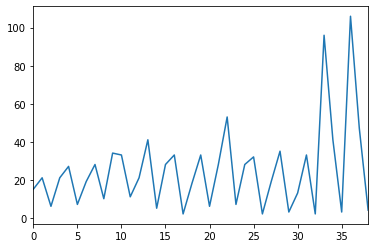

In [15]:
# Generate stat report by country

mcc = 240

account_id = 172720

df3 = df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['REP_DATE']).reset_index()
display(df3)

df3['charge'].plot()
plt.show()

,,,,quantity,cost,charge
REP_DATE,mcc,mnc,account_id,,,
2020-02-15,228,3,172794,435644530.0,1.0,3.0
2020-02-16,228,3,172794,148258625.0,0.0,1.0
2020-02-17,228,3,172794,332607615.0,1.0,2.0
2020-02-18,228,3,172794,365544369.0,1.0,2.0
2020-02-19,228,3,172794,397208390.0,1.0,2.0
2020-02-20,228,3,172794,110845090.0,138.0,275.0


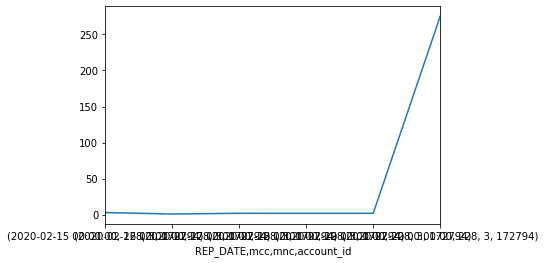

In [30]:
# Generate stat report by country and Operator

mcc = 228
mnc = 3
account_id = 172794

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['mnc','REP_DATE'])
display(df3)

df3['charge'].plot()
plt.show()

### Report by Subscriber

In [13]:
# Download data from OCS DB

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select   
min(u.USAGE_DATE) USAGE_DATE
,u.SUBSCRIBER_ID
,si.IMSI
,si.ICCID
,spn.PHONE_NUMBER
,a.ACCOUNT_NAME
,u.MCC
,u.MNC
,n.NETWORK_NAME
,c.COUNTRY_NAME
,ut.USAGE_TYPE
,sum(uc.CHARGE) Charge
,sum(uc.CHARGE_QUANTITY) Quantity
,u.DEST_PHONE_NUMBER
,u.SESSION_ID
from [10028_usage2019-04].dbo.usage u
inner join [10028_usage2019-04].dbo.USAGE_CHARGES uc on u.USAGE_ID=uc.USAGE_ID
right join [10028].dbo.SUBSCRIBER_IMSIS si on u.SUBSCRIBER_ID = si.SUBSCRIBER_ID and si.END_DATE is null
right join [10028].dbo.SUBSCRIBER_PHONE_NUMBERS spn on u.SUBSCRIBER_ID = spn.SUBSCRIBER_ID and spn.END_DATE is null
inner join [10028].dbo.USAGE_TYPE ut on u.USAGE_TYPE = ut.USAGE_TYPE_ID
right join [10028].dbo.SUBSCRIBERS s on s.SUBSCRIBER_ID = u.SUBSCRIBER_ID
right join [10028].dbo.ACCOUNTS a on a.ACCOUNT_ID = s.ACCOUNT_ID
right join [10028].dbo.RDB_NETWORK_IMSI_PREFIXES net on net.MCC = u.MCC and net.MNC= u.MNC
right join [10028].dbo.RDB_NETWORKS n on net.NETWORK_ID = n.NETWORK_ID
right join [10028].dbo.RDB_COUNTRIES c on c.COUNTRY_ID = n.COUNTRY_ID
where uc.ACCOUNT_ID = 352406 AND u.MCC IN (621, 334)
AND u.USAGE_DATE BETWEEN '2019-04-07 00:00:00' AND '2019-04-09 00:00:00'
group by   u.SUBSCRIBER_ID,
si.IMSI, si.ICCID , spn.PHONE_NUMBER,a.ACCOUNT_NAME,
u.MCC , u.MNC  , n.NETWORK_NAME , c.COUNTRY_NAME, ut.USAGE_TYPE,
u.SESSION_ID , u.DEST_PHONE_NUMBER
order by min(u.USAGE_DATE),u.SUBSCRIBER_ID
'''

df_subscribers = pd.read_sql_query(sql_srt, cnxn, parse_dates={'USAGE_DATE': '%d/%m/%ysort'})
cnxn.close()

df_subscribers.head()

,USAGE_DATE,SUBSCRIBER_ID,IMSI,ICCID,PHONE_NUMBER,ACCOUNT_NAME,MCC,MNC,NETWORK_NAME,COUNTRY_NAME,USAGE_TYPE,Charge,Quantity,DEST_PHONE_NUMBER,SESSION_ID
0,2019-04-07 00:06:24.387,1573717,724390000684331,89553900030006843312,5512974034185,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00001,0.00025,None,d0-EPGrh.live.partner.com;1538597561;55767709;...
1,2019-04-07 00:30:25.747,1573501,724390993549584,89553900230061175630,5511957516715,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.82394,22.88730,None,d1-EPGrh.live.partner.com;1538597562;55793236;...
2,2019-04-07 00:41:49.357,1573668,724390003308068,89553900030033080680,5511975450828,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00000,0.00010,None,d1-EPGrh.live.partner.com;1528923558;130278919...
3,2019-04-07 01:07:00.697,1573698,724390996140658,89553910300006736388,5511948346245,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.19620,5.45000,None,d0-EPGrh.live.partner.com;1528923558;129735267...
4,2019-04-07 01:29:27.200,1573581,724390999264340,89553910300020011834,5511940195221,Nextel,621,20,Airtel/ZAIN/Econet,Nigeria,Incoming Text,0.00000,1.00000,None,18022718-1554593357


In [15]:
df_subscribers['REP_DATE'] = df_subscribers.USAGE_DATE.dt.strftime('%Y-%m-%d')

In [18]:
downloads = 'C:/Users/balob/Downloads'
df_subscribers.groupby(['REP_DATE','IMSI','MCC','USAGE_TYPE','DEST_PHONE_NUMBER'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by='Charge',
                                                                              ascending=False).head(15)

,REP_DATE,IMSI,MCC,USAGE_TYPE,DEST_PHONE_NUMBER,Charge,Quantity
39,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531253,65.2740,94.60000
86,2019-04-08,724390999264281,621,VOIP Outgoing Call,236750531296,61.2030,88.70000
134,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531250,57.3505,83.11667
163,2019-04-08,724390999264339,621,VOIP Outgoing Call,236750531299,55.0045,79.71666
43,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531299,46.6900,67.66667
96,2019-04-08,724390999264289,621,VOIP Outgoing Call,236750531255,44.8500,65.00000
124,2019-04-08,724390999264292,621,VOIP Outgoing Call,236750531253,42.1130,61.03333
135,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531296,41.4230,60.03333
25,2019-04-07,724390999264337,621,VOIP Outgoing Call,236750531299,41.4115,60.01667
115,2019-04-08,724390999264291,621,VOIP Outgoing Call,236750531254,41.4000,60.00000


In [22]:
df_subscribers.groupby(['IMSI','MCC','USAGE_TYPE'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by=['IMSI','Charge'],
                                                                              ascending=False).head(25)

,IMSI,MCC,USAGE_TYPE,Charge,Quantity
45,724390999264340,621,VOIP Outgoing Call,137.54600,199.20000
44,724390999264340,621,Outgoing Call,101.00000,202.00000
43,724390999264340,621,Incoming Text,0.00000,2.00000
42,724390999264339,621,VOIP Outgoing Call,142.91500,206.78334
41,724390999264339,621,Outgoing Call,101.00001,201.99999
40,724390999264339,621,Incoming Text,0.00000,2.00000
39,724390999264338,621,VOIP Outgoing Call,276.29800,400.18335
38,724390999264338,621,Outgoing Call,201.00000,402.00000
37,724390999264338,621,Incoming Text,0.00000,2.00000
36,724390999264337,621,VOIP Outgoing Call,140.08150,203.01667
